In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
rcParams['pdf.fonttype'] = 42  # Use TrueType fonts
rcParams['axes.linewidth'] = 0.5
rcParams['xtick.major.width'] = 0.5
rcParams['ytick.major.width'] = 0.5

In [23]:
import sys
import os
import pandas as pd
import numpy as np
from os.path import join as pjoin
from catrace.stats import sort_conditions, pool_training_conditions
from catrace.visualize import plot_measure, plot_all_measures

dataset_name = 'simulation'
config_file = f'../dataset_configs/{dataset_name}_dataset.json'

In [24]:
from catrace.dataset import load_dataset_config
dsconfig= load_dataset_config(config_file)

capacity_dir = os.path.join(dsconfig.results_dir, 'capacity')
#data_version_tag = ''
data_version_tag = 'smallnet_v3'
window = [11, 29]
seed = 123
window_key = f'window_{window[0]}_{window[1]}'

jobname = f'capacity_{window_key}'
N = 1000
M=50

jobname = f'capacity_sweep_{window_key}_N{N}_M{M}_master_seed{seed}'


conditions = dsconfig.conditions

input_dir = pjoin(capacity_dir, jobname)
exp_list = dsconfig.exp_list

# If file exists, load it
df_result_file = pjoin(input_dir, f'df_result.pkl')
df_result = pd.read_pickle(df_result_file)


def rename_odor_index_levels(df_per_fish):
    df_per_fish.reset_index(level=['odor_0', 'odor_1'], inplace=True)
    # Rename columns odor_0 to odor1 and odor_1 to odor2
    df_per_fish.rename(columns={'odor_0': 'odor1', 'odor_1': 'odor2'}, inplace=True)
    # Set odor1 and odor2 as index
    df_per_fish.set_index(['odor1', 'odor2'], inplace=True, append=True)
    return df_per_fish

df_per_fish_juv = df_result.xs(False, level='shuffle').groupby(['fish_id', 'condition', 'odor1', 'odor2'], sort=False).mean()
df_per_fish_juv_shuffled = df_result.xs(True, level='shuffle').groupby(['fish_id', 'condition', 'odor1', 'odor2'], sort=False).mean()

#df_per_fish_juv = rename_odor_index_levels(df_per_fish_juv)
#df_per_fish_juv_shuffled = rename_odor_index_levels(df_per_fish_juv_shuffled)

juv_conditions =  ['rand', 'both_n', 'scaled_n']
cond_mapping = {'rand': 'naive', 'both_n': 'trained', 'scaled_n': 'trained'}
conditions_pooled = ['naive', 'trained']

df_pooled = pool_training_conditions(df_per_fish_juv, cond_mapping)

df_pooled_shuffled = pool_training_conditions(df_per_fish_juv_shuffled, cond_mapping)


[('aa2', 'ba1'), ('ba1', 'ba2'), ('aa2', 'ba3'), ('aa3', 'ba3'), ('aa2', 'ba2'), ('aa3', 'ba2'), ('aa1', 'aa2'), ('ba2', 'ba3'), ('aa1', 'ba1'), ('aa3', 'ba1'), ('aa1', 'ba2'), ('aa1', 'aa3'), ('aa2', 'aa3'), ('ba1', 'ba3'), ('aa1', 'ba3')]
    Contrast       A         B  Paired  Parametric         T    dof  \
0  condition  both_n      rand   False        True  5.546731  238.0   
1  condition  both_n  scaled_n   False        True -4.348312  238.0   
2  condition    rand  scaled_n   False        True -6.552299  238.0   

  alternative         p-unc       BF10    hedges  
0   two-sided  7.724845e-08  1.489e+05  0.713821  
1   two-sided  2.034881e-05    836.655 -0.559594  
2   two-sided  3.472071e-10  2.469e+07 -0.843230  
[('aa2', 'ba1'), ('ba1', 'ba2'), ('aa2', 'ba3'), ('aa3', 'ba3'), ('aa2', 'ba2'), ('aa3', 'ba2'), ('aa1', 'aa2'), ('ba2', 'ba3'), ('aa1', 'ba1'), ('aa3', 'ba1'), ('aa1', 'ba2'), ('aa1', 'aa3'), ('aa2', 'aa3'), ('ba1', 'ba3'), ('aa1', 'ba3')]
    Contrast       A         

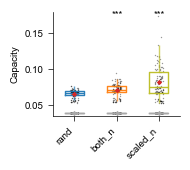

In [ ]:
from catrace.stats import sort_conditions
from catrace.visualize import plot_measure_by_cond, PlotBoxplotByCondParams
from catrace.capacity_utils import get_group_vs_group
from dataclasses import replace

 # figsize=(4,6), ax_label_fontsize=22, xtick_label_fontsize=18, ytick_label_fontsize=16, star_fontsize=20, box_linewidth=4
def plot_stat_by_cond_with_shuffled(df_per_fish, df_per_fish_shuffled,
                                    conditions,
                                    with_shuffled=False, 
                                    plot_measure_params=PlotBoxplotByCondParams(),
                                    measure_name='capacity'):
    
    vsname = 'all_vs_all'
    odor1_group = dsconfig.odors_stimuli
    odor2_group = dsconfig.odors_stimuli

    dff = get_group_vs_group(df_per_fish, odor1_group, odor2_group)
    dff= sort_conditions(dff, conditions)


    fig, ax, test_results_raw = plot_measure_by_cond(dff, measure_name=measure_name, test_type='kruskal', params=plot_measure_params)
    if with_shuffled:
        updated_params = replace(plot_measure_params,
                            box_color='darkgrey',
                            box_colors=None,
                            ylevel_scale=1.2,
                            mean_marker_color='darkgrey')
        dff_shuffled = get_group_vs_group(df_per_fish_shuffled, odor1_group, odor2_group)
        dff_shuffled = sort_conditions(dff_shuffled, conditions)
        fig, ax, test_results_shuffled = plot_measure_by_cond(dff_shuffled, measure_name=measure_name, test_type='kruskal', ax=ax, params=updated_params)
        return fig, test_results_raw, test_results_shuffled
    return fig, test_results_raw

from catrace.dataset import load_dataset_config
dsconfig = load_dataset_config(config_file)
juv_conditions = dsconfig.conditions

color_dict = {'naive': 'tab:blue', 
              'both_n': 'tab:orange',
              'scaled_n': 'tab:olive',
}
plot_measure_params = PlotBoxplotByCondParams(
    figsize=(2.0, 1.8),
    box_linewidth=1,
    mean_marker_size=0.7,
    strip_size=1,
    ylim=(0.035, 0.18),
    pvalue_marker_xoffset=0.2,
    box_colors= color_dict.values(),
    #['tab:blue', 'tab:brown', 'tab:green', 'tab:pink'],#['tab:blue', 'tab:orange'],
    ylevel_scale=0.95,
    naive_name='rand',
    box_width: float = 0.45,
)
fig, test_results_raw, test_results_shuffled = plot_stat_by_cond_with_shuffled(df_per_fish_juv, df_per_fish_juv_shuffled, juv_conditions, with_shuffled=True, plot_measure_params=plot_measure_params, measure_name='capacity')

from catrace.visualize import set_yticks_interval
set_yticks_interval(fig.get_axes()[0], 0.05)

from catrace.for_paper import save_figure_for_paper
fig_dir = f'../figures/{dataset_name}'
os.makedirs(fig_dir, exist_ok=True)
save_figure_for_paper(fig, f'simulation_capacity', fig_dir)


[('aa2', 'ba1'), ('ba1', 'ba2'), ('aa2', 'ba3'), ('aa3', 'ba3'), ('aa2', 'ba2'), ('aa3', 'ba2'), ('aa1', 'aa2'), ('ba2', 'ba3'), ('aa1', 'ba1'), ('aa3', 'ba1'), ('aa1', 'ba2'), ('aa1', 'aa3'), ('aa2', 'aa3'), ('ba1', 'ba3'), ('aa1', 'ba3')]
    Contrast       A         B  Paired  Parametric         T    dof  \
0  condition  both_n      rand   False        True -2.440502  238.0   
1  condition  both_n  scaled_n   False        True  0.905633  238.0   
2  condition    rand  scaled_n   False        True  2.935484  238.0   

  alternative     p-unc   BF10    hedges  
0   two-sided  0.015397  2.306 -0.314074  
1   two-sided  0.366046  0.208  0.116548  
2   two-sided  0.003656  7.897  0.377774  
[('aa2', 'ba1'), ('ba1', 'ba2'), ('aa2', 'ba3'), ('aa3', 'ba3'), ('aa2', 'ba2'), ('aa3', 'ba2'), ('aa1', 'aa2'), ('ba2', 'ba3'), ('aa1', 'ba1'), ('aa3', 'ba1'), ('aa1', 'ba2'), ('aa1', 'aa3'), ('aa2', 'aa3'), ('ba1', 'ba3'), ('aa1', 'ba3')]
    Contrast       A         B  Paired  Parametric         T 

[('aa2', 'ba1'), ('ba1', 'ba2'), ('aa2', 'ba3'), ('aa3', 'ba3'), ('aa2', 'ba2'), ('aa3', 'ba2'), ('aa1', 'aa2'), ('ba2', 'ba3'), ('aa1', 'ba1'), ('aa3', 'ba1'), ('aa1', 'ba2'), ('aa1', 'aa3'), ('aa2', 'aa3'), ('ba1', 'ba3'), ('aa1', 'ba3')]
    Contrast       A         B  Paired  Parametric         T    dof  \
0  condition  both_n      rand   False        True -1.033085  238.0   
1  condition  both_n  scaled_n   False        True  4.700146  238.0   
2  condition    rand  scaled_n   False        True  5.896414  238.0   

  alternative         p-unc       BF10    hedges  
0   two-sided  3.026125e-01      0.234 -0.132950  
1   two-sided  4.401745e-06   3430.637  0.604872  
2   two-sided  1.265282e-08  8.181e+05  0.758822  
[('aa2', 'ba1'), ('ba1', 'ba2'), ('aa2', 'ba3'), ('aa3', 'ba3'), ('aa2', 'ba2'), ('aa3', 'ba2'), ('aa1', 'aa2'), ('ba2', 'ba3'), ('aa1', 'ba1'), ('aa3', 'ba1'), ('aa1', 'ba2'), ('aa1', 'aa3'), ('aa2', 'aa3'), ('ba1', 'ba3'), ('aa1', 'ba3')]
    Contrast       A         

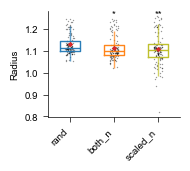

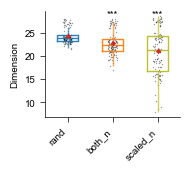

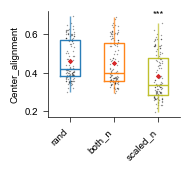

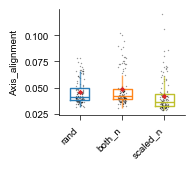

In [26]:
# Plot geometrical measures
measure_names = ['radius', 'dimension', 'center_alignment', 'axis_alignment']
ylim_list = [None, None, None, None]
tick_interval_list = [None, None, None, None]

for idx, measure_name in enumerate(measure_names):
    # Copyt plot_params_copy
    ylim = ylim_list[idx]
    plot_measure_params_copy = replace(plot_measure_params,
                                 ylim=ylim)
    fig, test_results_raw = plot_stat_by_cond_with_shuffled(df_per_fish_juv, df_per_fish_juv_shuffled, juv_conditions, with_shuffled=False, plot_measure_params=plot_measure_params_copy, measure_name=measure_name)
    tick_interval = tick_interval_list[idx]
    if tick_interval is not None:
        set_yticks_interval(fig.get_axes()[0], tick_interval)
    save_figure_for_paper(fig, f'simulation_{measure_name}', fig_dir)